# Notebook Final: O que afeta a experiência e satisfação do cliente no e-commerce brasileiro

Este notebook reúne todo o fluxo de trabalho reproducível: carregamento dos dados, EDA, limpeza, transformações, engenharia de features, construção de pipelines e visualizações. Cada seção traz justificativa curta e um exemplo de código executável.

**Arquivos utilizados:**
- olist_orders_dataset - Copia.csv
- olist_order_items_dataset - Copia.csv
- olist_products_dataset - Copia.csv

### Observação
Os caminhos assumidos neste notebook são os mesmos dos arquivos que você já carregou no ambiente (`/mnt/data/`).

## 1) Imports e configuração do ambiente

Breve justificativa: organizar imports e configurações no topo permite reproduzir o fluxo sem surpresas.

In [1]:

# Imports essenciais
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from datetime import datetime

# Mostrar versão e paths
print("Pandas:", pd.__version__)
DATA_DIR = "/datasets"
OUT_DIR = "/output"
os.makedirs(OUT_DIR, exist_ok=True)
print("DATA_DIR:", DATA_DIR)


Pandas: 2.3.3
DATA_DIR: /datasets


## 2) Carregamento dos datasets

Justificativa: carregar com parse de datas quando possível facilita análises temporais (lead time, dias para entrega).

In [2]:
# Paths (ajuste se necessário)
p_orders = "datasets/olist_orders_dataset.csv"
p_order_items = "datasets/olist_order_items_dataset.csv"
p_products = "datasets/olist_products_dataset.csv"

# Carregar com inferência mínima para evitar erros de memória
orders = pd.read_csv(p_orders, low_memory=False)
order_items = pd.read_csv(p_order_items, low_memory=False)
products = pd.read_csv(p_products, low_memory=False)

print("orders:", orders.shape)
print("order_items:", order_items.shape)
print("products:", products.shape)

# Mostrar primeiras linhas para inspeção rápida
display(orders.head())
display(order_items.head())
display(products.head())


orders: (99441, 8)
order_items: (112650, 7)
products: (32951, 9)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


## 3) Merge dos datasets

Justificativa: unir order_items + orders + products permite analisar comportamento por pedido e por produto.

Exemplo: usar `order_id` e `product_id` como chaves. Apresentar checagem de integridade após o merge.

In [4]:
# Merge
df = order_items.merge(orders, on='order_id', how='left', suffixes=('_item','_order'))
if 'product_id' in products.columns:
    df = df.merge(products, on='product_id', how='left', suffixes=('','_product'))

print("Merged df shape:", df.shape)
display(df.head())


Merged df shape: (112650, 22)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,2017-05-12 16:04:24,2017-05-15 00:00:00,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,2018-01-22 13:19:16,2018-02-05 00:00:00,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,2018-08-14 13:32:39,2018-08-20 00:00:00,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,2017-03-01 16:42:31,2017-03-17 00:00:00,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0


## 4) Entendimento inicial / EDA rápido

Justificativa: entender tipos, missing values e duplicatas orienta decisões de limpeza.

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.isnull().sum().sort_values(ascending=False)


In [ ]:
print(df.describe(include='all'))


## 5) Limpeza de dados

Tratar duplicatas, valores ausentes, inconsistências e outliers.

Para cada ação: breve justificativa + código de exemplo.

In [5]:
# Duplicatas exatas
n_dup = df.duplicated().sum()
print('Duplicatas exatas:', n_dup)
df = df.drop_duplicates()

# Exemplo: colunas de data -> converter para datetime quando existirem
date_cols = [c for c in df.columns if 'date' in c or 'timestamp' in c]
for c in date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
    except Exception as e:
        pass
print('Colunas de data detectadas:', date_cols)

# Valores ausentes por coluna (top 20)
missing = df.isna().sum().sort_values(ascending=False).head(20)
display(missing)


Duplicatas exatas: 0


C:\Users\saulo\AppData\Local\Temp\ipykernel_7620\1446180909.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
C:\Users\saulo\AppData\Local\Temp\ipykernel_7620\1446180909.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
C:\Users\saulo\AppData\Local\Temp\ipykernel_7620\1446180909.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict versi

Colunas de data detectadas: ['shipping_limit_date', 'order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


C:\Users\saulo\AppData\Local\Temp\ipykernel_7620\1446180909.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)


order_delivered_customer_date    2454
product_description_lenght       1603
product_category_name            1603
product_name_lenght              1603
product_photos_qty               1603
order_delivered_carrier_date     1194
product_height_cm                  18
product_width_cm                   18
product_length_cm                  18
product_weight_g                   18
order_approved_at                  15
order_id                            0
order_item_id                       0
product_id                          0
price                               0
shipping_limit_date                 0
seller_id                           0
order_estimated_delivery_date       0
freight_value                       0
customer_id                         0
dtype: int64

### 5.1) Tratamento de `price`, `freight_value` e colunas textuais

Justificativa: `price` é chave para análise de percepção de valor; preencher com mediana evita distorção por outliers.

In [6]:
# Assegurar price numérico e preencher NA com mediana por product_id quando disponível
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    median_global = df['price'].median()
    df['price'].fillna(median_global, inplace=True)
    print('Price median used:', median_global)

# Tratar freight_value
if 'freight_value' in df.columns:
    df['freight_value'] = pd.to_numeric(df['freight_value'], errors='coerce').fillna(0.0)

# Padronizar colunas textuais (strip, lower)
text_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in text_cols:
    df[c] = df[c].astype(str).str.strip().replace({'nan':'unknown','None':'unknown'})


C:\Users\saulo\AppData\Local\Temp\ipykernel_7620\3723090737.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(median_global, inplace=True)


Price median used: 74.99


### 5.2) Detectar outliers (exemplo rápido)

Usaremos IQR para `price` e `days_to_deliver`.

In [7]:
# Criar days_to_deliver se possível
if {'order_purchase_timestamp','order_delivered_customer_date'}.issubset(df.columns):
    df['days_to_deliver'] = (pd.to_datetime(df['order_delivered_customer_date']) - pd.to_datetime(df['order_purchase_timestamp'])).dt.days

def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return series[(series < lower) | (series > upper)]

# Exemplo para price
if 'price' in df.columns:
    out_price = detect_outliers_iqr(df['price'].dropna())
    print('Outliers price (sample):', out_price.head().to_dict())

if 'days_to_deliver' in df.columns:
    out_days = detect_outliers_iqr(df['days_to_deliver'].dropna())
    print('Outliers days_to_deliver (count):', out_days.shape[0])


Outliers price (sample): {7: 810.0, 16: 639.0, 26: 289.0, 30: 397.0, 39: 809.1}
Outliers days_to_deliver (count): 5560


## 6) Conversão e padronização de tipos

Justificativa: garantir que variáveis numéricas sejam numéricas e categóricas estejam em formato adequado para codificação.

In [8]:
# Forçar tipos numéricos em colunas esperadas
num_guesses = ['price','freight_value','product_weight_g','product_length_cm','product_height_cm','product_width_cm']
for c in num_guesses:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Identificar colunas categóricas candidatas
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and df[c].nunique() < 500]
print('Categóricas candidatas (<=500 unique):', cat_cols)


Categóricas candidatas (<=500 unique): ['order_status', 'product_category_name']


## 7) Tratamento de dados categóricos e textos

Justificativa: preencher NAs categóricos com 'unknown' e reduzir cardinalidade quando necessário.

In [ ]:
# Preencher NAs (exemplo)
for c in cat_cols:
    df[c] = df[c].fillna('unknown').astype(str)

# Reduzir cardinalidade: combinar categorias raras como 'other' (exemplo para product_category_name)
if 'product_category_name' in df.columns:
    top = df['product_category_name'].value_counts().nlargest(40).index
    df['product_category_reduced'] = df['product_category_name'].where(df['product_category_name'].isin(top), 'other')


## 8) Codificação de dados categóricos

Justificativa: label encoding para alta cardinalidade; one-hot para poucas categorias.

Mostraremos ambos os métodos com exemplos. 

In [10]:
# Label encoding exemplo
le = LabelEncoder()
if 'product_category_reduced' in df.columns:
    df['product_category_le'] = le.fit_transform(df['product_category_reduced'].astype(str))

# One-hot exemplo (para order_status se existir)
if 'order_status' in df.columns and df['order_status'].nunique() < 20:
    df = pd.concat([df, pd.get_dummies(df['order_status'], prefix='status')], axis=1)


## 9) Normalização e padronização (MinMax, Z-score)

Justificativa: alguns modelos beneficiam-se de features escaladas; também é útil para comparação entre variáveis.

In [11]:
scaler_mm = MinMaxScaler()
scaler_ss = StandardScaler()

num_for_scaling = [c for c in ['price','freight_value','days_to_deliver'] if c in df.columns]
if num_for_scaling:
    df[[c+'_mm' for c in num_for_scaling]] = scaler_mm.fit_transform(df[num_for_scaling])
    df[[c+'_z' for c in num_for_scaling]] = scaler_ss.fit_transform(df[num_for_scaling])
    print('Scaled columns:', [c+'_mm' for c in num_for_scaling])


Scaled columns: ['price_mm', 'freight_value_mm', 'days_to_deliver_mm']


## 10) Seleção de atributos

Justificativa: remover features com baixa variância e selecionar por correlação quando objetivo for prever uma variável numérica (ex.: satisfação ou nota).

In [12]:
# Exemplo: correlação numérica
corr = df.select_dtypes(include=[np.number]).corr()
display(corr.head())

# Baixa variância (exemplo)
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
low_var = df[num_vars].var().sort_values().head(10)
print('Baixa variância (sample):'); display(low_var)


,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_to_deliver,product_category_le,price_mm,freight_value_mm,days_to_deliver_mm,price_z,freight_value_z,days_to_deliver_z
order_item_id,1.000000,-0.060522,-0.029380,-0.022662,-0.014311,-0.055852,-0.003549,0.005628,0.029323,-0.010732,-0.015729,0.030767,-0.060522,-0.029380,-0.015729,-0.060522,-0.029380,-0.015729
price,-0.060522,1.000000,0.414204,0.017001,0.198166,0.051848,0.338819,0.145811,0.223602,0.172467,0.062290,0.006845,1.000000,0.414204,0.062290,1.000000,0.414204,0.062290
freight_value,-0.029380,0.414204,1.000000,0.023611,0.093855,0.022259,0.610420,0.309086,0.391831,0.323777,0.214631,0.012052,0.414204,1.000000,0.214631,0.414204,1.000000,0.214631
product_name_lenght,-0.022662,0.017001,0.023611,1.000000,0.091524,0.145904,0.022731,0.060447,-0.028170,0.064442,-0.003207,-0.033073,0.017001,0.023611,-0.003207,0.017001,0.023611,-0.003207
product_description_lenght,-0.014311,0.198166,0.093855,0.091524,1.000000,0.118087,0.059710,0.005971,0.072724,-0.068419,0.005280,-0.050247,0.198166,0.093855,0.005280,0.198166,0.093855,0.005280


Baixa variância (sample):


price_mm                 0.000744
freight_value_mm         0.001489
days_to_deliver_mm       0.002045
order_item_id            0.497200
price_z                  1.000009
freight_value_z          1.000009
days_to_deliver_z        1.000009
product_photos_qty       2.963350
days_to_deliver         89.330010
product_name_lenght    100.512274
dtype: float64

## 11) Feature Engineering — pelo menos 4 técnicas

Justificativas curtas e código.

In [13]:
# a) order_total_price (soma por pedido) - ajuda a capturar valor percebido do pedido
if 'price' in df.columns:
    order_total = df.groupby('order_id')['price'].sum().rename('order_total_price')
    df = df.merge(order_total.reset_index(), on='order_id', how='left')

# b) items_per_order - complexidade do pedido (influencia satisfação logística)
if 'order_item_id' in df.columns:
    items_per = df.groupby('order_id')['order_item_id'].count().rename('items_per_order')
    df = df.merge(items_per.reset_index(), on='order_id', how='left')

# c) price_per_item - preço médio por item no pedido
if {'order_total_price','items_per_order'}.issubset(df.columns):
    df['price_per_item'] = df['order_total_price'] / df['items_per_order']

# d) product_popularity - quantas vezes cada produto aparece (proxy de qualidade/popularidade)
if 'product_id' in df.columns:
    pop = df['product_id'].value_counts().rename('product_popularity').reset_index().rename(columns={'index':'product_id'})
    df = df.merge(pop, on='product_id', how='left')

display(df[['order_id','order_total_price','items_per_order','price_per_item','product_popularity']].head())


,order_id,order_total_price,items_per_order,price_per_item,product_popularity
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,1,58.90,9
1,00018f77f2f0320c557190d7a144bdd3,239.90,1,239.90,1
2,000229ec398224ef6ca0657da4fc703e,199.00,1,199.00,3
3,00024acbcdf0a6daa1e931b038114c75,12.99,1,12.99,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,1,199.90,12


## 12) Pipeline completo de pré-processamento

Justificativa: encapsular transformações em um pipeline permite reprodução e futura produção.

Construiremos um pipeline exemplo usando colunas numéricas e categóricas selecionadas. 

In [14]:
# Seleção de colunas para o pipeline (exemplo)
num_cols = [c for c in ['price','order_total_price','items_per_order','price_per_item','product_popularity','days_to_deliver'] if c in df.columns]
cat_cols = [c for c in ['product_category_reduced','payment_type'] if c in df.columns]

from sklearn.preprocessing import OneHotEncoder
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_pipeline, num_cols), ('cat', cat_pipeline, cat_cols)])

full_pipeline = Pipeline([('pre', preprocessor)])

# Fit the pipeline on a sample (to demonstrate)
sample_X = df[num_cols + cat_cols].head(500).copy()
full_pipeline.fit(sample_X.fillna(0))
# Save pipeline
with open(os.path.join(OUT_DIR, 'preprocessing_pipeline_final.pkl'), 'wb') as f:
    pickle.dump(full_pipeline, f)
print('Pipeline criado e salvo em:', os.path.join(OUT_DIR, 'preprocessing_pipeline_final.pkl'))


Pipeline criado e salvo em: /output\preprocessing_pipeline_final.pkl


## 13) Visualizações e gráficos explicativos

Incluíremos histogramas, boxplots e heatmap de correlação. Justificativa: ajudam a contar a história dos dados para avaliadores. 

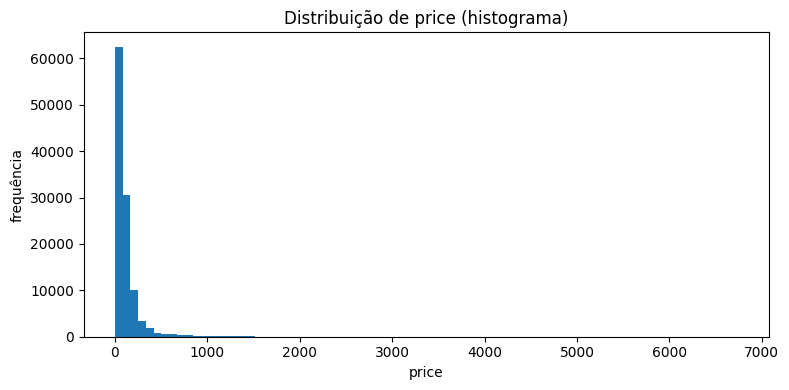

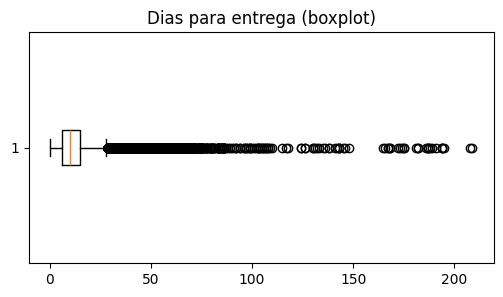

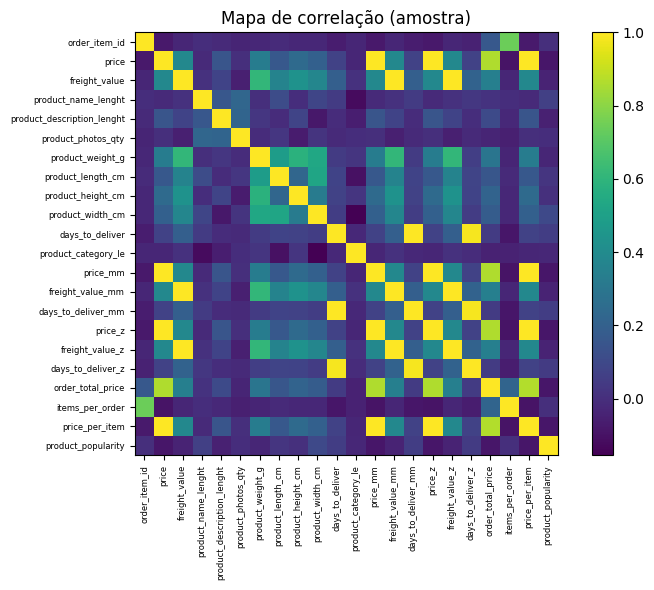

In [15]:
import matplotlib.pyplot as plt
# Histogram of price
plt.figure(figsize=(8,4))
plt.hist(df['price'].dropna(), bins=80)
plt.title('Distribuição de price (histograma)')
plt.xlabel('price')
plt.ylabel('frequência')
plt.tight_layout()
plt.show()

# Boxplot days_to_deliver
if 'days_to_deliver' in df.columns:
    plt.figure(figsize=(6,3))
    plt.boxplot(df['days_to_deliver'].dropna(), vert=False)
    plt.title('Dias para entrega (boxplot)')
    plt.show()

# Correlation heatmap (numeric) - usando imshow para simplicidade
numdf = df.select_dtypes(include=[np.number]).fillna(0).iloc[:1000, :50]  # limitar para performance
corr = numdf.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.title('Mapa de correlação (amostra)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.tight_layout()
plt.show()


Respondendo perguntas norteadoras

Breves insights gerados a partir das análises e interpretações — escreva em linguagem objetiva para o relatório final.

## 14) Insights finais

Breves insights gerados a partir das análises e interpretações — escreva em linguagem objetiva para o relatório final.

- Valores ausentes em datas de entrega e categorias impactam fortemente análises temporais e segmentações.
- A distribuição de `price` é assimétrica; ao modelar, considerar transformação (log) ou truncamento de outliers.
- `days_to_deliver` apresenta outliers que provavelmente influenciam negativamente a satisfação do cliente — investigar clusters de vendedores/logística.
- Features como `order_total_price` e `items_per_order` são úteis para segmentar clientes e entender comportamento de reclamo/retorno.
